In [2]:
%load_ext autoreload
%autoreload 2
from torch.utils.data import DataLoader
import torch
import pytorch_lightning as pl
from pathlib import Path
import os
import time
import datetime
import yaml
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)

import logging

from tqdm.notebook import tqdm

import volpick.model.models as models
import seisbench.models as sbm
import seisbench.generate as sbg
from volpick.model.utils import load_best_model_from_base_dir,load_best_model
import seisbench.data as sbd
from volpick.model.generate_eval_targets import generate_task0, generate_task1, generate_task23

from volpick.model.models import phase_dict
from volpick.model.eval_taks0 import evaluate, get_ground_truth, count_TP_FP_FN, compute_residuals, calculate_precision_recall_F1score, eval_task0, opt_prob_metrics, collect_task0_results,collect_task0_results_dev,opt_prob_metrics_dev
from volpick.model.eval_taks123 import eval_tasks123,collect_task123_results

import json

from sklearn.metrics import roc_curve, precision_recall_curve, roc_auc_score
from scipy.stats import rankdata

In [ ]:
models_root_path = Path("/home/zhongyiyuan/volpick/model_training/weights_swa")
# model_dirs=["e_1024_0.001_gau20_2_st", "e_256_0.001_gau20_2_st", "e_256_0.01_tri20_2_st"]
model_dirs = [x.name for x in models_root_path.iterdir()]
model_dirs

True
(401,)
400
0.0424102805554866
/home/zhongyiyuan/volpick/model_training/weights_swa/p/version_0


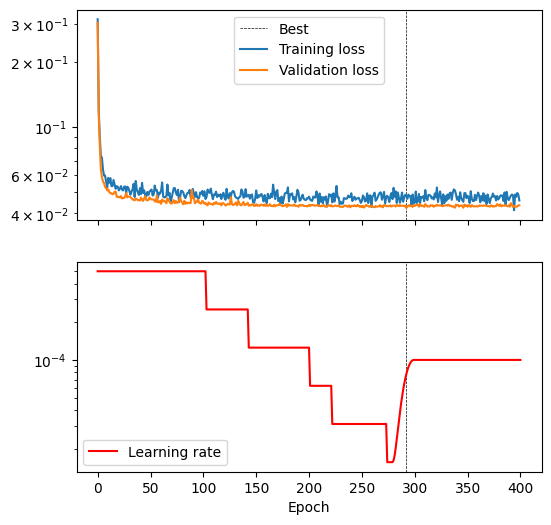

In [44]:
# for model_dirname in model_dirs:
model_path = models_root_path / "p"
pl_model = load_best_model_from_base_dir(model_path)

# Data

In [645]:
data_path = Path("/home/zhongyiyuan/DATA/my_datasets_seisbench/vcseis")

dataset = sbd.WaveformDataset(
    data_path,
    sampling_rate=100,
    component_order="ZNE",
    dimension_order="NCW",
    cache="full",
)
dataset.filter(dataset["split"].isin(["dev", "test"]), inplace=True)
dataset.preload_waveforms(pbar=True)

Preloading waveforms: 100%|██████████| 52864/52864 [00:10<00:00, 5027.92it/s]


In [646]:
dataset_lp_and_noise = dataset.filter(
    (dataset.metadata["source_type"] == "lp")
    | (dataset.metadata["source_type"] == "noise"),
    inplace=False,
)
dataset_rg_and_noise = dataset.filter(
    (dataset.metadata["source_type"] != "lp")
    | (dataset.metadata["source_type"] == "noise"),
    inplace=False,
)
print("Number of traces in the test set and the development set:")
print(f"{len(dataset_lp_and_noise)} lp and noise traces")
print(f"{len(dataset_rg_and_noise)} vt and noise traces")

print(f"""{len(dataset.metadata[dataset.metadata["source_type"]=="lp"])} lp traces""")
print(
    f"""{len(dataset.metadata[(dataset.metadata["source_type"]!="lp")&(dataset.metadata["source_type"]!="noise")])} regular earthquake traces"""
)
print(
    f"""{len(dataset.metadata[dataset.metadata["source_type"]=="noise"])} noise earthquake traces"""
)

Number of traces in the test set and the development set:
30168 lp and noise traces
30235 vt and noise traces
22629 lp traces
22696 regular earthquake traces
7539 noise earthquake traces


In [647]:
# full data set
targets_path_lp_and_rg = Path(
    "/home/zhongyiyuan/volpick/model_training/Eval_targets/all"
)
try:
    targets_path_lp_and_rg.mkdir(parents=True, exist_ok=False)
except FileExistsError:
    print(f"{targets_path_lp_and_rg} exists")

# LP and noise
targets_path_lp = Path(
    "/home/zhongyiyuan/volpick/model_training/Eval_targets/lp_and_noise"
)
try:
    targets_path_lp.mkdir(parents=True, exist_ok=False)
except FileExistsError:
    print(f"{targets_path_lp} exists")

# VT and noise
targets_path_rg = Path(
    "/home/zhongyiyuan/volpick/model_training/Eval_targets/rg_and_noise"
)
try:
    targets_path_rg.mkdir(parents=True, exist_ok=False)
except FileExistsError:
    print(f"{targets_path_rg} exists")

/home/zhongyiyuan/volpick/model_training/Eval_targets/all exists
/home/zhongyiyuan/volpick/model_training/Eval_targets/lp_and_noise exists
/home/zhongyiyuan/volpick/model_training/Eval_targets/rg_and_noise exists


# Model

In [37]:
1 - 1 / (400 * 0.2)

0.9875

True
Min val_loss: 304, 0.0426393188536167
Min train_loss: 259, 0.0432704091072082
/home/zhongyiyuan/volpick/model_training/weights_ema/p/version_1
True
Min val_loss: 331, 0.01572728715837
Min train_loss: 214, 0.0166747663170099
/home/zhongyiyuan/volpick/model_training/weights_ema/e/version_1


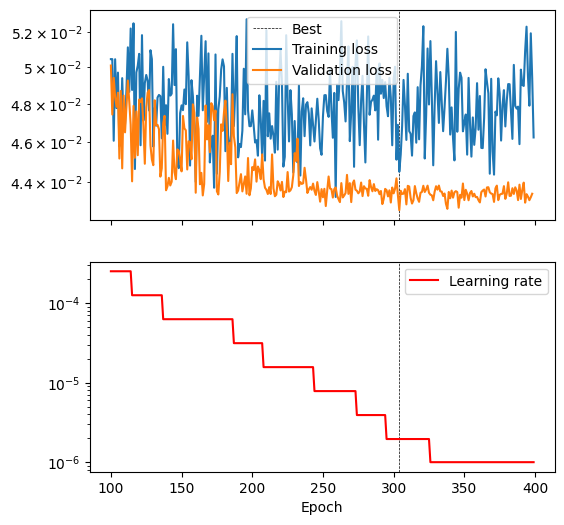

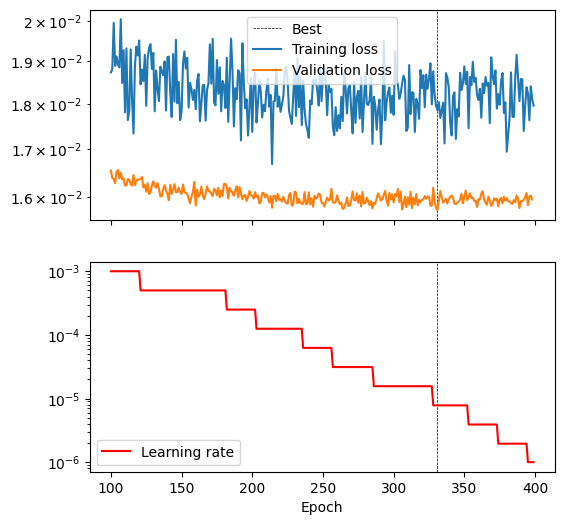

In [659]:
models_root_path = Path("/home/zhongyiyuan/volpick/model_training/weights_ema")
# model_dirs=["e_1024_0.001_gau20_2_st", "e_256_0.001_gau20_2_st", "e_256_0.01_tri20_2_st"]
model_dirs = [x.name for x in models_root_path.iterdir()]
model_dirs

for model_dirname in model_dirs:
    model_path = models_root_path / model_dirname
    pl_model = load_best_model_from_base_dir(
        model_path,
        ema=True,
        # plot_val_loss=False,
        # version=0,
        # last=True,
        # monitor="train_loss"
        start_epoch_plot=100,
    )

True
Min val_loss: 292, 0.0420240610837936
Min train_loss: 394, 0.040949922055006
/home/zhongyiyuan/volpick/model_training/weights/p_512_5e-04_ga20_400_s/version_0
True
Min val_loss: 331, 0.0157418083399534
Min train_loss: 336, 0.0171123053878545
/home/zhongyiyuan/volpick/model_training/weights/e_1024_1e-03_ga20_400_s_preinstance/version_0


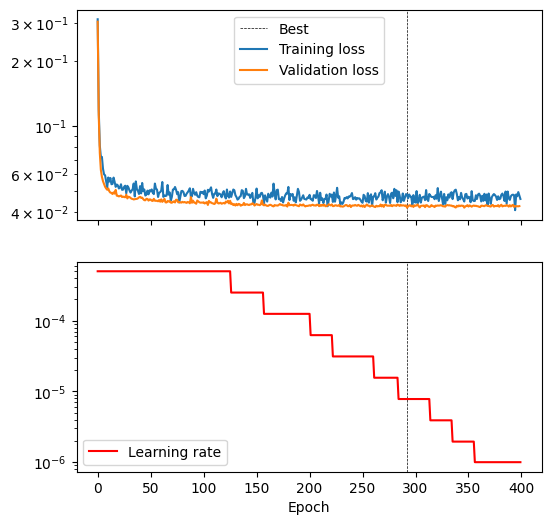

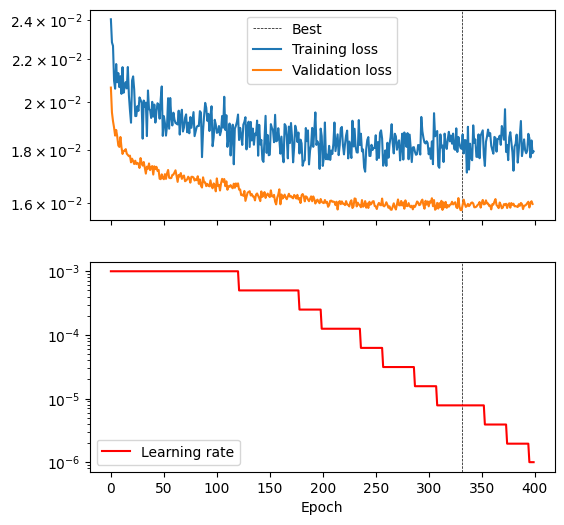

In [653]:
models_root_path = Path("/home/zhongyiyuan/volpick/model_training/weights")
# model_dirs=["e_1024_0.001_gau20_2_st", "e_256_0.001_gau20_2_st", "e_256_0.01_tri20_2_st"]
# model_dirs = [x.name for x in models_root_path.iterdir()]
model_dirs = ["p_512_5e-04_ga20_400_s", "e_1024_1e-03_ga20_400_s_preinstance"]

for model_dirname in model_dirs:
    model_path = models_root_path / model_dirname
    pl_model = load_best_model_from_base_dir(
        model_path,
        # ema=True,
        # plot_val_loss=False,
        # version=0,
        # last=True,
        # monitor="train_loss"
        start_epoch_plot=0,
    )

True
Min val_loss: 60, 0.0785832554101944
Min train_loss: 53, 0.0466635413467884
/home/zhongyiyuan/volpick/model_training/weights_ema/p/version_0
True
Min val_loss: 25, 0.0251355413347482
Min train_loss: 19, 0.0191289074718952
/home/zhongyiyuan/volpick/model_training/weights_ema/e/version_0


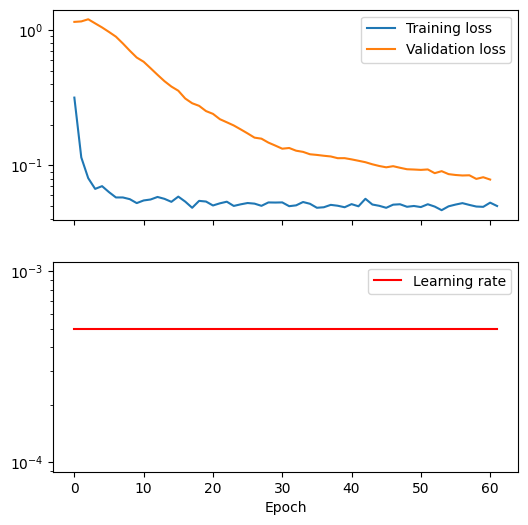

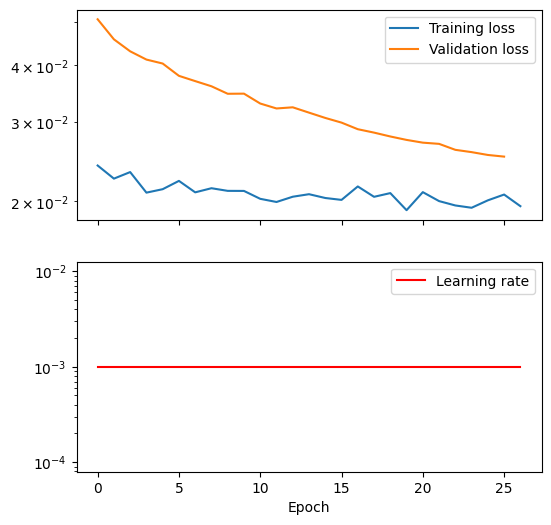

In [219]:
models_root_path = Path("/home/zhongyiyuan/volpick/model_training/weights_ema")
# model_dirs=["e_1024_0.001_gau20_2_st", "e_256_0.001_gau20_2_st", "e_256_0.01_tri20_2_st"]
model_dirs = [x.name for x in models_root_path.iterdir()]
model_dirs

for model_dirname in model_dirs:
    model_path = models_root_path / model_dirname
    pl_model, pl_model_last = load_best_model_from_base_dir(
        model_path, last=True, monitor="val_loss"
    )

# Threshold

In [660]:
tp_thre = 0.5
# target_path_list=[targets_path_lp_and_rg, targets_path_lp, targets_path_rg]
# dataset_list=[dataset, dataset_lp_and_noise, dataset_rg_and_noise]

target_path_list = [targets_path_lp_and_rg]
dataset_list = [dataset]

# for model_dirname in model_dirs:
model_path = models_root_path / "p"
pl_model, pl_model_last = load_best_model_from_base_dir(
    model_path, last=True, plot_loss=False, ema=True
)
model = pl_model.model
for target_i, dataset_i in zip(target_path_list, dataset_list):
    eval_task0(
        dev_test_set=dataset_i,
        model=model,
        exp_name=f"{model_path.name}",
        targets_path=target_i,
        root_save_dir="/home/zhongyiyuan/volpick/model_training/Eval_ema",
        # prob_thres=np.array([0.27,0.3,0.32]),
        # prob_thres=np.array([0.13,0.15,0.17,0.20,0.22,0.23,0.24,0.25,0.26,0.27,0.3,0.32,0.35]), #,0.24,0.245,0.25,0.255,0.26,0.265,0.27,0.28,0.29,0.3
        prob_thres=np.arange(0.12, 0.42, 0.01),
        num_workers=32,
        batchsize=2048,
        num_test_run=-1,
        output_remark="pred",
        tp_thre=tp_thre,
        sets=["dev"],
        # sets=["train", "dev","test"],
        # append_to_file=True,
        data_norm_type=model.norm,
    )

/home/zhongyiyuan/volpick/model_training/Eval_ema/all_pred/task0/e exists
Starting set: dev


Preloading waveforms: 100%|██████████| 17744/17744 [00:00<00:00, 344804.93it/s]

Number of examples in dev: 17744
15190 earthquake traces
2554 noise traces
Probability threshold: 0.1200


Probability threshold: 0.1300
Probability threshold: 0.1400
Probability threshold: 0.1500
Probability threshold: 0.1600
Probability threshold: 0.1700
Probability threshold: 0.1800
Probability threshold: 0.1900
Probability threshold: 0.2000
Probability threshold: 0.2100
Probability threshold: 0.2200
Probability threshold: 0.2300
Probability threshold: 0.2400
Probability threshold: 0.2500
Probability threshold: 0.2600
Probability threshold: 0.2700
Probability threshold: 0.2800
Probability threshold: 0.2900
Probability threshold: 0.3000
Probability threshold: 0.3100
Probability threshold: 0.3200
Probability threshold: 0.3300
Probability threshold: 0.3400
Probability threshold: 0.3500
Probability threshold: 0.3600
Probability threshold: 0.3700
Probability threshold: 0.3800
Probability threshold: 0.3900
Probability threshold: 0.4000
Probability threshold: 0.4100



In [59]:
tp_thre = 0.5
# target_path_list=[targets_path_lp_and_rg, targets_path_lp, targets_path_rg]
# dataset_list=[dataset, dataset_lp_and_noise, dataset_rg_and_noise]

target_path_list = [targets_path_lp_and_rg]
dataset_list = [dataset]

# for model_dirname in model_dirs:
model_path = models_root_path / "e"
pl_model, pl_model_last = load_best_model_from_base_dir(
    model_path, last=True, plot_loss=False,ema=True
)
model = pl_model_last.model
for target_i, dataset_i in zip(target_path_list, dataset_list):
    eval_task0(
        dev_test_set=dataset_i,
        model=model,
        exp_name=f"{model_path.name}",
        targets_path=target_i,
        root_save_dir="/home/zhongyiyuan/volpick/model_training/Eval_swa",
        # prob_thres=np.array([0.27,0.3,0.32]),
        # prob_thres=np.array([0.13,0.15,0.17,0.20,0.22,0.23,0.24,0.25,0.26,0.27,0.3,0.32,0.35]), #,0.24,0.245,0.25,0.255,0.26,0.265,0.27,0.28,0.29,0.3
        prob_thres=np.arange(0.12, 0.42, 0.01),
        num_workers=32,
        batchsize=2048,
        num_test_run=-1,
        output_remark="pred",
        tp_thre=tp_thre,
        sets=["dev"],
        # sets=["train", "dev","test"],
        # append_to_file=True,
        data_norm_type=model.norm,
    )

/home/zhongyiyuan/volpick/model_training/Eval_swa/all_pred/task0/e exists
Starting set: dev


Preloading waveforms: 100%|██████████| 17744/17744 [00:00<00:00, 338051.51it/s]

Number of examples in dev: 17744
15190 earthquake traces
2554 noise traces
Probability threshold: 0.1200


Probability threshold: 0.1300
Probability threshold: 0.1400
Probability threshold: 0.1500
Probability threshold: 0.1600
Probability threshold: 0.1700
Probability threshold: 0.1800
Probability threshold: 0.1900
Probability threshold: 0.2000
Probability threshold: 0.2100
Probability threshold: 0.2200
Probability threshold: 0.2300
Probability threshold: 0.2400
Probability threshold: 0.2500
Probability threshold: 0.2600
Probability threshold: 0.2700
Probability threshold: 0.2800
Probability threshold: 0.2900
Probability threshold: 0.3000
Probability threshold: 0.3100
Probability threshold: 0.3200
Probability threshold: 0.3300
Probability threshold: 0.3400
Probability threshold: 0.3500
Probability threshold: 0.3600
Probability threshold: 0.3700
Probability threshold: 0.3800
Probability threshold: 0.3900
Probability threshold: 0.4000
Probability threshold: 0.4100



In [664]:
root_save_dir = Path("/home/zhongyiyuan/volpick/model_training/Eval_ema/all_pred/task0")
stats_list = []
for pred_dir in root_save_dir.iterdir():
    if pred_dir.is_dir():
        print(pred_dir)
        stats = opt_prob_metrics_dev(pred_dir)
        stats_list.append(stats)
df = pd.DataFrame(stats_list)

/home/zhongyiyuan/volpick/model_training/Eval_ema/all_pred/task0/p
/home/zhongyiyuan/volpick/model_training/Eval_ema/all_pred/task0/e


In [658]:
stats_list[0]

{'exp_name': 'p',
 'tp_thre': 0.5,
 'p_opt_prob_thre': 0.3500000000000002,
 's_opt_prob_thre': 0.3300000000000002,
 'dev_p_TP': 13832.0,
 'dev_p_FP': 1260.0,
 'dev_p_FN': 1358.0,
 'dev_p_precision': 0.9165120593692022,
 'dev_p_recall': 0.9105990783410138,
 'dev_p_F1score': 0.9135460009246416,
 'dev_p_mean': 0.0624066582664632,
 'dev_p_median': -0.01,
 'dev_p_std': 2.658505559160892,
 'dev_p_MAE': 0.5771025930101465,
 'dev_p_MAD': 0.04,
 'dev_p_out': 0.059221433782081,
 'dev_p_modified_mean': -0.0042031964984415,
 'dev_p_modified_median': -0.01,
 'dev_p_modified_std': 0.2850565484266187,
 'dev_p_modified_RMSE': 0.285078083853344,
 'dev_p_modified_MAE': 0.1331931825717885,
 'dev_p_modified_MAD': 0.04,
 'dev_p_modified_mean2': -0.009193343675081,
 'dev_p_modified_median2': -0.01,
 'dev_p_modified_std2': 0.1519133480520527,
 'dev_p_modified_RMSE2': 0.1521859245590804,
 'dev_p_modified_MAE2': 0.0783683542518685,
 'dev_p_modified_MAD2': 0.03,
 'dev_s_TP': 12697.0,
 'dev_s_FP': 1690.0,
 'dev_

In [665]:
stats_list[1]

{'exp_name': 'e',
 'tp_thre': 0.5,
 'p_opt_prob_thre': 0.2300000000000001,
 's_opt_prob_thre': 0.21,
 'dev_p_TP': 14035.0,
 'dev_p_FP': 1158.0,
 'dev_p_FN': 1155.0,
 'dev_p_precision': 0.9237806884749556,
 'dev_p_recall': 0.923963133640553,
 'dev_p_F1score': 0.9238719020504887,
 'dev_p_mean': -0.1375075727643882,
 'dev_p_median': 0.0,
 'dev_p_std': 2.198034898717081,
 'dev_p_MAE': 0.481715395759252,
 'dev_p_MAD': 0.05,
 'dev_p_out': 0.0541288028447254,
 'dev_p_modified_mean': -0.0200790201501382,
 'dev_p_modified_median': 0.0,
 'dev_p_modified_std': 0.2768528273164991,
 'dev_p_modified_RMSE': 0.2775709058901073,
 'dev_p_modified_MAE': 0.136664032661662,
 'dev_p_modified_MAD': 0.05,
 'dev_p_modified_mean2': -0.006330594624704,
 'dev_p_modified_median2': 0.0,
 'dev_p_modified_std2': 0.1550934142916937,
 'dev_p_modified_RMSE2': 0.1552171664181199,
 'dev_p_modified_MAE2': 0.0871313187578331,
 'dev_p_modified_MAD2': 0.04,
 'dev_s_TP': 12865.0,
 'dev_s_FP': 1670.0,
 'dev_s_FN': 1485.0,
 'dev